# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#clean portfolio
clean_portfolio = portfolio

In [3]:
#get dummy channel
clean_portfolio['channel_email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
clean_portfolio['channel_mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
clean_portfolio['channel_social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
clean_portfolio['channel_web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [4]:
clean_portfolio = clean_portfolio.drop(columns=['channels'])

In [5]:
# update id to offer_id
clean_portfolio = clean_portfolio.rename(columns={'id': 'offer_id'})


In [6]:
#get dummy offer type
clean_portfolio = pd.get_dummies(clean_portfolio, columns=['offer_type'])

In [7]:
# clean profile
clean_profile = profile
clean_profile = clean_profile.rename(columns={'id':'customer_id'})
# replacing the age = 118 by NaN
clean_profile['age'] = clean_profile['age'].apply(lambda x: np.nan if x == 118 else x)


In [8]:
#drop NAN data, if there is no information for age, there will be no information for other features.
clean_profile = clean_profile.dropna()
clean_profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
dtype: int64

In [9]:
#get dummy gender
clean_profile = pd.get_dummies(clean_profile, columns=['gender'])
clean_profile = clean_profile.drop(['gender_O'], axis=1)

In [10]:
# change become_member_on to the days as a member
clean_profile['became_member_on'] = pd.to_datetime(clean_profile['became_member_on'], format = '%Y%m%d')

In [11]:
import datetime

clean_profile['become_member_days'] = datetime.datetime.today().date() - clean_profile['became_member_on'].dt.date
clean_profile['become_member_days'] = clean_profile['become_member_days'].dt.days
clean_profile = clean_profile.drop(['became_member_on'], axis=1)


In [12]:
#clean transcripts
clean_transcript = transcript


In [13]:
clean_transcript.rename(columns={'person':'customer_id'},inplace=True)


In [14]:
#split value
key = []
for index, row in clean_transcript.iterrows():
    for k in row['value']:
        if k in key:
            continue
        else:
            key.append(k)
key

['offer id', 'amount', 'offer_id', 'reward']

In [15]:
#create columns 
clean_transcript['offer_id'] = '' 
clean_transcript['amount'] = 0.0 
clean_transcript['reward'] = 0.0 

In [16]:
#updating columns created above
for index, row in clean_transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': 
            clean_transcript.at[index, 'offer_id'] = row['value'][k]
        if k == 'amount':
            clean_transcript.at[index, 'amount'] = row['value'][k]
        if k == 'reward':
            clean_transcript.at[index, 'reward'] = row['value'][k]

In [17]:
# filling the no offer 
clean_transcript['offer_id'] = clean_transcript['offer_id'].apply(lambda x: 'no_offer' if x == '' else x)


In [18]:
#get dummy for event
clean_transcript = pd.get_dummies(clean_transcript, columns=['event'])

In [19]:
#rename get dummies columns
clean_transcript = clean_transcript.rename(columns={'event_offer completed': 'offer_compeleted'})

In [20]:
clean_transcript = clean_transcript.rename(columns={'event_offer received': 'offer_received'})
clean_transcript = clean_transcript.rename(columns={'event_offer viewed': 'offer_viewed'})
clean_transcript = clean_transcript.rename(columns={'event_transaction': 'transaction'})
clean_transcript = clean_transcript.drop(['value'],axis= 1)

In [21]:
# merge dataset
df_full =clean_transcript.merge(clean_portfolio,how='left',on='offer_id')
df_full = df_full.merge(clean_profile,how='left',on='customer_id')


In [22]:
# drop the row without people information
df_full_dna = df_full.dropna(subset=['age'])


In [24]:
#compare the gender like using offer and not using offer
female_trans = df_full_dna[df_full_dna['transaction']==1]['gender_F'].sum()

In [25]:
male_trans = df_full_dna[df_full_dna['transaction']==1]['gender_M'].sum()

In [26]:
#female ratio for transaction
female_ratio_tran = female_trans / (female_trans + male_trans)
female_ratio_tran

0.40418740178103718

In [27]:
#female ratio cheking offer

female_offer = df_full_dna[df_full_dna['transaction']==0]['gender_F'].sum()
male_offer = df_full_dna[df_full_dna['transaction']==0]['gender_M'].sum()


female_ratio_offer = female_offer / (female_offer + male_offer)
female_ratio_offer

0.43460082529072741

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
#compare the age like using offer and not using offer
df_full_size = df_full_dna[df_full_dna['transaction']==0]['age'].count()

In [30]:
df_full_trans_size = df_full_dna[df_full_dna['transaction']==1]['age'].count()

Text(0,0.5,'percentage')

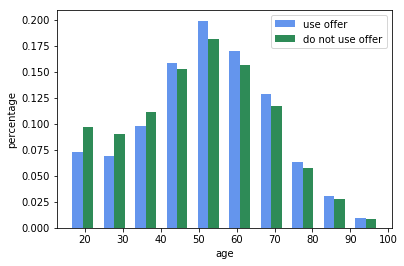

In [31]:
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(df_full_dna[df_full_dna['transaction']==0]['age'])
b_heights, b_bins = np.histogram(df_full_dna[df_full_dna['transaction']==1]['age'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights/df_full_size, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights/df_full_trans_size, width=width, facecolor='seagreen')
ax.legend(['use offer', 'do not use offer'])
plt.xlabel('age')
plt.ylabel('percentage')

Text(0,0.5,'percentage')

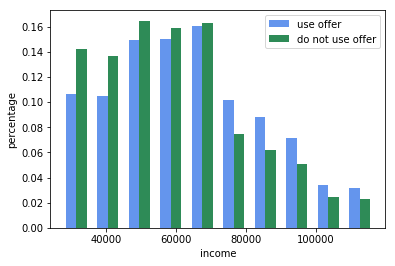

In [32]:
#compare the income like using offer and not using offer


df_full_size = df_full_dna[df_full_dna['transaction']==0]['income'].count()
df_full_trans_size = df_full_dna[df_full_dna['transaction']==1]['income'].count()
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(df_full_dna[df_full_dna['transaction']==0]['income'])
b_heights, b_bins = np.histogram(df_full_dna[df_full_dna['transaction']==1]['income'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights/df_full_size, width=width, facecolor='cornflowerblue')
ax.bar(b_bins[:-1]+width, b_heights/df_full_trans_size, width=width, facecolor='seagreen')
ax.legend(['use offer', 'do not use offer'])
plt.xlabel('income')
plt.ylabel('percentage')

In [33]:
#find the popular offer
# only keep the the data viewed the offer to see the information of completion
df_full_offer = df_full_dna[df_full_dna['transaction']==0]
df_full_offer = df_full_offer[df_full_offer['offer_received']==0]


In [35]:
#check the number of each type complete or just view the offer
df_full_offer_type = df_full_offer[['offer_type_bogo','offer_type_discount','offer_type_informational']]
df_full_offer_type_com = df_full_offer[df_full_offer['offer_compeleted']==1][['offer_type_bogo','offer_type_discount','offer_type_informational']]
 

In [36]:
df_full_offer_sum = df_full_offer_type.sum()
df_full_offer_com_sum = df_full_offer_type_com.sum()
df_full_offer_com_sum

offer_type_bogo             15258.0
offer_type_discount         17186.0
offer_type_informational        0.0
dtype: float64

Text(0,0.5,'number')

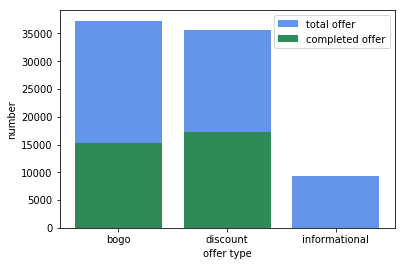

In [37]:



fig, ax = plt.subplots()



ax.bar(['bogo','discount','informational'],df_full_offer_sum, facecolor='cornflowerblue')
ax.bar(['bogo','discount','informational'],df_full_offer_com_sum, facecolor='seagreen')
ax.legend(['total offer', 'completed offer'])
plt.xlabel('offer type')
plt.ylabel('number')

In [38]:
# top10 features for people to complete the offer
df_top10 = df_full_offer.drop(['offer_id','customer_id','amount','offer_received','reward_x','offer_type_bogo','offer_type_discount','offer_type_informational','transaction'],axis =1)

In [39]:

Xb = df_top10.drop(['offer_compeleted','offer_viewed'],axis=1)
yb=df_top10['offer_compeleted']

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

reduce_Xb = Xb.iloc[:, np.where((Xb.sum() > 50) == True)[0]]
reduce_Xb = Xb
X_train, X_test, y_train, y_test = train_test_split(reduce_Xb, yb, test_size = .30, random_state=42) 
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
y_test_preds[y_test_preds>=0.5]=1
y_test_preds[y_test_preds<0.5]=0


In [41]:
from sklearn.metrics import accuracy_score
# Calculate the absolute errors
accuracy_score(y_test, y_test_preds)

0.63810140936335658

In [42]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(10)

,est_int,coefs,abs_coefs
7,channel_web,0.118305,0.118305
5,channel_mobile,0.104907,0.104907
6,channel_social,-0.081572,0.081572
2,duration,0.041578,0.041578
10,gender_F,0.022903,0.022903
11,gender_M,-0.018733,0.018733
3,reward_y,0.015082,0.015082
1,difficulty,0.006036,0.006036
0,time,0.000235,0.000235
12,become_member_days,0.000083,0.000083
